# Maps

files needed = ('cb_2018_us_state_5m.zip', 'cb_2018_us_county_5m.zip', '1000-largest-us-cities-by-population-with-geographic-coordinates.zip')

Okay, we now know enough about figures and pandas to get a map off the ground. 

We will use the geopandas package to plot our maps. Maps are really quite complicated. We are trying to project a spherical surface onto a flat figure, which is inherently a complicated endeavor. Luckily, geopandas will handle most of it for us. 

Geopandas extends pandas to include geospatial data. It provides plotting routines that work with matplotlib to create visualizations. 

In [1]:
import pandas as pd                         # pandas for data management
import geopandas                            # geopandas for maps work
from shapely.geometry import Point          # shapely handles the coordinate references for plotting shapes
import matplotlib.pyplot as plt             # matplotlib for plotting details

### Setting up the GeoDataFrame
Let's start by plotting some cities. The DataFrame below holds longitudes and latitudes of major South American cities. Our goal is to turn them into something we can plot---in this case, a GeoDataFrame.

In [2]:
cities = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})
cities.head()

,City,Country,Latitude,Longitude
0,Buenos Aires,Argentina,-34.58,-58.66
1,Brasilia,Brazil,-15.78,-47.91
2,Santiago,Chile,-33.45,-70.66
3,Bogota,Colombia,4.60,-74.08
4,Caracas,Venezuela,10.48,-66.86


We need tuples of coordinates to map the cities. We zip together lat and long to create the tuples and store them in a column named 'Coordinates'.

In [3]:
cities['Coordinates'] = list(zip(cities.Longitude, cities.Latitude))
cities.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,"(-58.66, -34.58)"
1,Brasilia,Brazil,-15.78,-47.91,"(-47.91, -15.78)"
2,Santiago,Chile,-33.45,-70.66,"(-70.66, -33.45)"
3,Bogota,Colombia,4.60,-74.08,"(-74.08, 4.6)"
4,Caracas,Venezuela,10.48,-66.86,"(-66.86, 10.48)"


So far, we haven't done anything that requires new packages. We just have a dataFrame full of numbers and strings.

Next, we turn the tuple into a [Point](http://toblerity.org/shapely/manual.html#spatial-data-model) object. Notice that we imported Point from the Shapely package in the first code cell. We use the `.apply()` method of DataFrame to apply the Point function to each row of the Coordinates column.

In [4]:
cities['Coordinates'] = cities['Coordinates'].apply(Point)
cities.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66 -34.58)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91 -15.78)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66 -33.45)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08 4.6)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86 10.48)


We now have a column of Point objects. 

We turn the DataFrame into a **GeoDataFrame**, which is a data structure that understands how to plot maps. The **important** part here is that we specify the column that contains the `geometery` data. From the [docs](http://geopandas.org/data_structures.html):

> The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column.

In our case, the geometry data are the points in the 'Coordinates' column. 

In [5]:
gcities = geopandas.GeoDataFrame(cities, geometry='Coordinates')
gcities.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [6]:
# Doesn't look different than a vanilla DataFrame...let's make sure we have what we want.
print('gdf is of type:', type(gcities))

# And how can we tell which column is the geometry column?
print('\nThe geometry column is:', gcities.geometry.name)

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>

The geometry column is: Coordinates


### Plotting the map
Okay, we have our points in the GeoDataFrame. Let's plot the locations on a map. We proceed in three steps:
1. Get the map
2. Plot the map
3. Plot the points on the map


### 1. Get the map
[Natural Earth](https://www.naturalearthdata.com/) is the name of the organiztion that compiled the map data. The file provides the outlines of countries over which we will plot the locations of the cities in our GeoDataFrame. Geopandas comes with this data bundled into it, so we do not have to go get it. Thanks geopandas! 

In [7]:
# Datasets that ship with geopandas. Makes for easy practicing. 
# A dataset on cities, country boundries, and New York City borough boundries
geopandas.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [8]:
# Step 1: Get the map. 
# geopandas comes with some datasets that define maps. 
# Here, we grab a low-resolution Natural Earth map and load it into a GeoDataFrame.
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.sample(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
95,25248140,Asia,North Korea,PRK,40000.0,"MULTIPOLYGON (((130.78000 42.22001, 130.78000 ..."
84,6072475,Asia,United Arab Emirates,ARE,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."
145,9961396,Asia,Azerbaijan,AZE,167900.0,"MULTIPOLYGON (((46.40495 41.86068, 46.68607 41..."
37,6172011,North America,El Salvador,SLV,54790.0,"POLYGON ((-89.35333 14.42413, -89.05851 14.340..."
134,279070,Oceania,New Caledonia,NCL,10770.0,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7..."
125,3047987,Europe,Albania,ALB,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
129,11491346,Europe,Belgium,BEL,508600.0,"POLYGON ((6.15666 50.80372, 6.04307 50.12805, ..."
32,47698524,South America,Colombia,COL,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011..."
76,8299706,Asia,Israel,ISR,297000.0,"POLYGON ((35.71992 32.70919, 35.54567 32.39399..."


In [9]:
# Which column holds the geometry data?
world.geometry.name

'geometry'

This is another GeoDataFrame. The geometry data are the column named 'geometry'. 

### A quick word about polygons


Instead of Points, the geometery are POLYGONs. The polygons are the shapes of countries. 

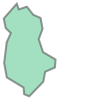

In [10]:
world = world.set_index('name')

# Hello Albania
world.loc['Albania','geometry']

Wow, that was cool.

A polygon is a loop of points connected by straight lines (e.g., triangle or rectangle). The more points we have, the closer the polygon can approximate non-linear shapes. So Albania's shape is defined by many points connected by lines.  

In [11]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc['Albania','geometry'].exterior.coords.xy

# How many points?
print('Points in the exterior of Albania:', len(x))


Points in the exterior of Albania: 24


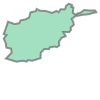

In [12]:
# Afghanistan is a more complicated shape
world.loc['Afghanistan','geometry']

In [13]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc['Afghanistan', 'geometry'].exterior.coords.xy

# How many points?
print('Points in the exterior of Afghanistan:', len(x))

Points in the exterior of Afghanistan: 69


### 2. Ploting the map

Here is the code. Details in the cell below it. 

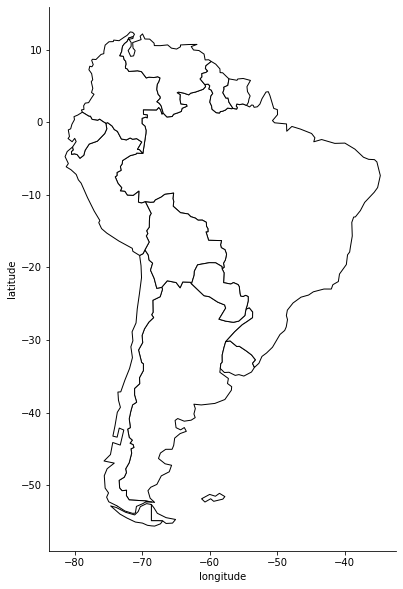

In [14]:
# Step 2: Plot the map

fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world[world['continent'] == 'South America'].plot(ax = gax, edgecolor='black',color='white')

gax.set_xlabel('longitude')  # By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()


### GeoDataFrame plots
Nice one! That was easy, and now we have a map. 

Note the different syntax for plot. We have been using the `plot()` method of matplotlib axes objects, so we usually called 
```python
gax.plot(x, y)
```
which plotted x against y on the axis gax. 

With a GeoDataFrame, we invoke the `plot()` method of a GeoDataFrame object with
```
gdf.plot(ax = gax)
```
which will **plot the geometry data in gdf** on the axis gax.  This is similar to the syntax that seaborn uses. 

### Other options
Notice that lots of the regular matplotlib options still work. I can still turn off the top and right spines (do I want to?) and I can add x and y axes labels. The parameter 'edgecolor' sets the line colors, etc. 

It looks like I didn't put a title on my plot. Poor form. Let's fix it when we add the cities. 

### 3. Plot the cities on the map

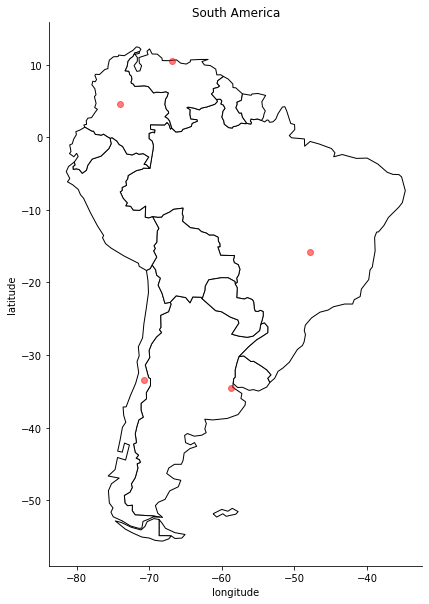

In [15]:
# Step 3: plot the cities onto the map
# We mostly use the code from before --- we still want the country borders ploted --- and we add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world[world['continent'] == 'South America'].plot(ax = gax, edgecolor='black',color='white')

# This plot the cities. It's the same sytax, but we are plotting from a different GeoDataFrame. 
# I want the cities as pale red dots. 
gcities.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')  
gax.set_ylabel('latitude')
gax.set_title('South America')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

This looks pretty nice. What else might we want to do? 

* Maybe add some labels to the points? We can add labels to the figure using `text()` just like we would in a regular figure. We need to be a little careful about specifying where to put the label. We do this below if you are interested.
* I would probably kill all the axis, unless knowing the latitude and longitude is important. 

## Practice: Maps

Let's plot Wisconsin and all of its counties. Along the way, we will learn where to find 'shape files' for U.S. states and counties. Shape files hold the polygons of areas. 

The steps:

1. Plot the state border
2. Plot the county borders
3. Plot the cities


We'll do the first step together. 

### 1. Plot the state border
Go to [https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)  


Here we find shapefiles for all kinds of maps: states, counties, congressional districts, zip codes. These are the *cartographic boundary files*. They are simplified maps. For example, they do not include the tiny islands off the Wisconsin coast, even though those islands are part of the state. These simplified files are not meant for navigation, but for "thematic" mapping. Which is what we are doing. [Here](https://www.census.gov/programs-surveys/geography/technical-documentation/naming-convention/cartographic-boundary-file.html) is some background on the files. 


We are going to work with the '5m' state border file. This means the resolution of the map is 1:5,000,000. There are 1:500,000 and 1:20,000,000 files, too. Different resolutions carry different levels of detail. You can experiment with the different shapefiles and see the differences. 

It's a zipped file. Put it in your cwd and uzip it. We need all of the files in the unzipped folder. Pass the '.shp' file to `geopandas.read_file()` which works like other 'read' methods from pandas, but will create a geoDataFrame.  

In [18]:
states = geopandas.read_file('cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


In [19]:
# What do we have here...
print(type(states))
print(states.geometry.name)

<class 'geopandas.geodataframe.GeoDataFrame'>
geometry


This is already set up with the correct geometry and ready to go. 

Plot the Wisconsin border. 

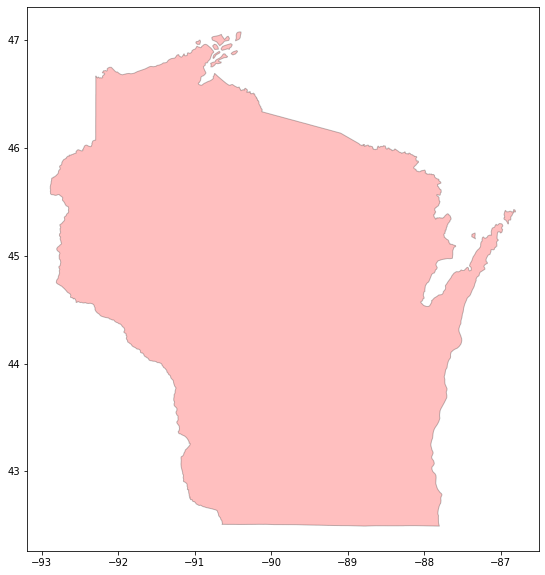

In [23]:
fig, gax = plt.subplots(figsize=(10,10))

# Only take the state named 'Wisconsin'
states[states['NAME'] == 'Wisconsin'].plot(ax = gax, edgecolor='black',color='red', alpha= 0.25)

plt.show()

### 2. Plot the county borders

Let's add the county borders. To do so, we first need to get the shape files. Again, let's use the '5m' files.

Like before, read the file in to a GeoDataFrame. 

This GeoDataFrame has all the counties in it. We only want the ones from Wisconsin. The Wisconsin federal information processing standard [(fips)](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696) code is 55. Keep only counties from Wisconsin. (A chance to practice our subsetting!) 

Plot the counties onto the same map as the state border. You will probably want to resue the code from above. 

In [24]:
#2
counties = geopandas.read_file('cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


In [38]:
# Sconie's fips code is 55. Keep only those counties
wi_counties = counties[counties['STATEFP']=='55']   # the state codes came in as text. should look into this...

# Give it a quick sort so we can take a look
wi_counties = wi_counties.sort_values('NAME')       # is Adams county here?
wi_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
2910,55,001,01581060,0500000US55001,55001,Adams,06,1672240387,108332661,"POLYGON ((-90.02595 44.09175, -89.92339 44.152..."
2657,55,003,01581061,0500000US55003,55003,Ashland,06,2706476264,3230710864,"MULTIPOLYGON (((-90.77692 47.02432, -90.74018 ..."
826,55,005,01581062,0500000US55005,55005,Barron,06,2235229317,69246614,"POLYGON ((-92.15489 45.63974, -92.03142 45.639..."
2337,55,007,01581063,0500000US55007,55007,Bayfield,06,3827694061,1460287292,"POLYGON ((-91.55134 46.75748, -91.51108 46.757..."
1185,55,009,01581064,0500000US55009,55009,Brown,06,1372933176,221808928,"POLYGON ((-88.25226 44.66743, -88.24269 44.679..."


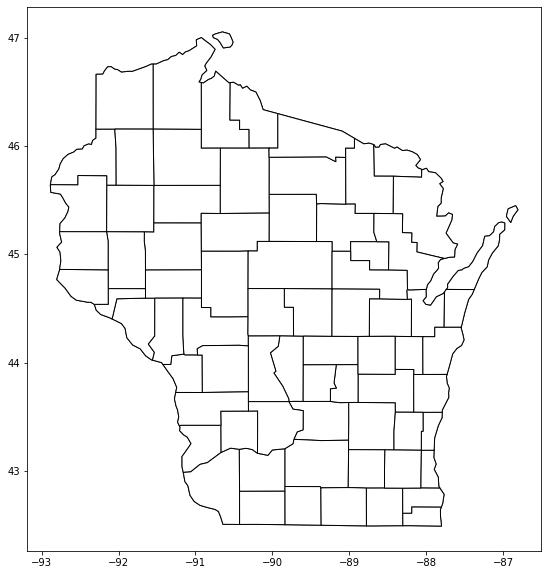

In [39]:
fig, gax = plt.subplots(figsize=(10,10))

# Only take the state named 'Wisconsin'
counties[counties['STATEFP'] == '55'].plot(ax = gax, edgecolor='black',color='lavender')
wi_counties.plot(ax=gax, edgecolor='black', color = 'white')
plt.show()

## 3. Plot some cities

From [this](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank) website, I download a dataset with some Wisconsin cities in it. The zip file is posted on the course website. It has an obnoxiously long name, but it's free data, so I do not want to complain too much. 

Put the file in your cwd and unzip it. Use the 
```python 
'1000-largest-us-cities-by-population-with-geographic-coordinates.shp'
```
file to load the data. The data include the location of the cities and their populations. There are 20 cities that rank among the 1000 largest cities. I did not know that. 

Add the cities to your plot. I made my cities blue dots.


In [30]:
#3
wi_cities = geopandas.read_file('1000-largest-us-cities-by-population-with-geographic-coordinates/1000-largest-us-cities-by-population-with-geographic-coordinates.shp')
wi_cities.tail()

,city,rank,state,growth_from,population,geometry
15,Oshkosh,515.0,Wisconsin,5.3,66778.0,POINT (-88.54261 44.02471)
16,Sheboygan,766.0,Wisconsin,-3.9,48725.0,POINT (-87.71453 43.75083)
17,Madison,83.0,Wisconsin,15.8,243344.0,POINT (-89.40123 43.07305)
18,Janesville,545.0,Wisconsin,5.6,63820.0,POINT (-89.01872 42.68279)
19,Green Bay,272.0,Wisconsin,1.9,104779.0,POINT (-88.01983 44.51916)


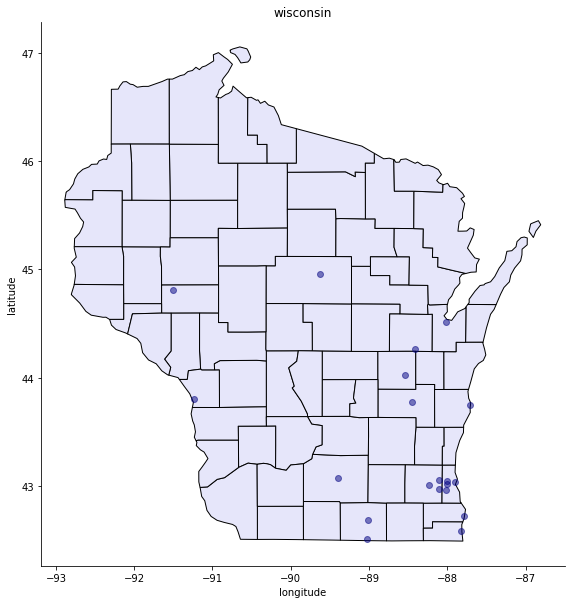

In [34]:

fig, gax = plt.subplots(figsize=(10,10))

counties[counties['STATEFP'] == '55'].plot(ax = gax, edgecolor='black',color='lavender')

wi_cities.plot(ax=gax, color='navy', alpha = 0.5)

gax.set_xlabel('longitude')  
gax.set_ylabel('latitude')
gax.set_title('wisconsin')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

## Projections

You might be looking at our figure and thinking that Wisconsin looks too fat compared to some [other maps we have seen](https://www.nytimes.com/elections/2016/results/wisconsin). (There are some good jokes to insert here, but I will leave them too you all.) 

We are trying to represent a spherical object (the Earth) on a flat surface. Doing so deforms the shapes. How shapes are modified to be represented on a 2-dimensional plane depends on the projection method. Projections are complicated and I do not know too much about them.  

We can change the projection of our figures by changing the *coordinate reference system* of our data. We check the crs using the crs property of a geoDataFrame. 

In [35]:
states.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

The crs is [4269](https://epsg.io/4269). Many of us are used to seeing Mercator projected maps. Mercator is [3395](https://epsg.io/3395). 

We change the crs using the `.to_crs()` method of geoDataFrame.

In [40]:
states=states.to_crs({'init': 'epsg:3395'})
wi_counties = wi_counties.to_crs({'init': 'epsg:3395'}) 
wi_cities = wi_cities.to_crs({'init': 'epsg:3395'})

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


*Note: In some cases I have had trouble changing the crs. It took a really (really, really) long time.* 

Okay, now let's plot again. 

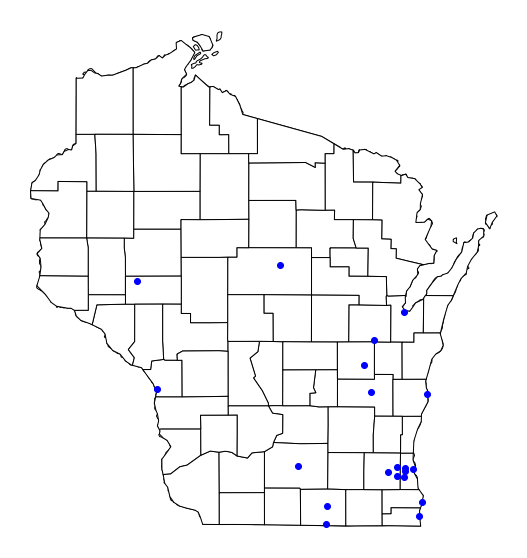

In [41]:
fig, gax = plt.subplots(figsize=(10,10))

# Plot the state outline
states[states['NAME'] == 'Wisconsin'].plot(ax = gax, edgecolor='black',color='white')

# Plot the counties
wi_counties.plot(ax=gax, edgecolor='black', color = 'white')

# Plot the cities
wi_cities.plot(ax=gax, color='blue')

plt.axis('off')

plt.show()

## Extra: details on labeling maps

### Label the points

Let's return to the South American map from earlier and label the points with the city names. 

Each label is our usual `.text()` method. It would be tedious to type all of those in, so let's automate this. Here is the code, we describe it below. 

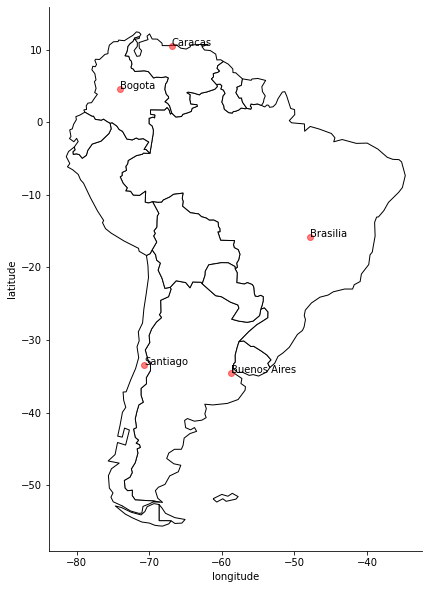

In [42]:
# Step 3: plot the cities onto the map
# We mostly use the code from before --- we still want the country borders ploted --- and we add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well, South America.
world[world['continent'] == 'South America'].plot(ax = gax, edgecolor='black',color='white')

# This plot the cities. It's the same sytax, but we are plotting from a different GeoDataFrame. I want the 
# cities as pale red dots. 
gcities.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')  
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Label the cities
for x, y, label in zip(gcities['Coordinates'].x, gcities['Coordinates'].y, gcities['City']):
    gax.text(x, y, label)

plt.show()

### Adding labels to points
That took more work than I expected. Let's talk through that code. The first bit of code is 
```python
for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['City']):
```
1. `for` is looping over the rows of the GeoDataFrame
2. `gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['City']` takes the x part of the coordinate, the y part of the coordinate and the name of the city for the row being looped over.
3. `zip()` combines the x-coord, the y-coord, and the name together ([zip](https://docs.python.org/3.3/library/functions.html#zip) is a handy function that takes multiple iterable objects and aggregates them together) 
4. `x, y, label` will hold the three values. 

So, for each row the `for` loops over, x is the x-coord, y is the y-coord, and label is the city name for city defined in that row. We use this data with `.text()` to apply the label at point (x,y)
```python
gax.text(x , y, label)
```

### Improving the labels
The labels get the job done, but they are a bit ugly. In particular, they are sitting on top of the dot. 

We can use `annotate()` to fix this up. We have used `annotate()` before to add arrows connecting the text to a point. Here, we will use the ability to specify an offset of the text from the point. Here is the syntax
```python
gax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')
```
The parameter 'xy' is the point we are referencing. The parameter 'xytext' hold the number of points to offset the text from the point. The argument 'offset points' tells annotate that the (3,3) tuple we passed to 'xytext' is full of points to offset the label from the text.  

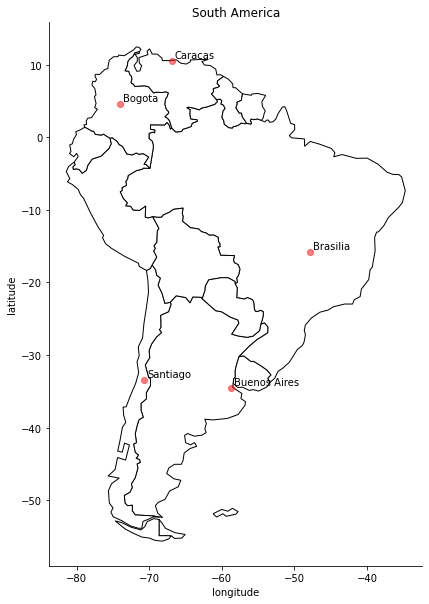

In [43]:
# Step 3: plot the cities onto the map
# We mostly use the code from before --- we still want the country borders ploted --- and we add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well, South America.
world[world['continent'] == 'South America'].plot(ax = gax, edgecolor='black',color='white')

# This plot the cities. It's the same sytax, but we are plotting from a different GeoDataFrame. I want the 
# cities as pale red dots. 
gcities.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')  
gax.set_ylabel('latitude')
gax.set_title('South America')

# Kill the spines...
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# ...or get rid of all the axis. Is it important to know the lat and long?
# plt.axis('off')


# Label the cities
for x, y, label in zip(gcities['Coordinates'].x, gcities['Coordinates'].y, gcities['City']):
    gax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')

plt.show()

## Practice

Add the names of the Wisconsin cities to your map.

This is a good start, but the cities around Milwaukee are a mess. These would have to be tweaked by hand. 